In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image, display_html, display, Math, HTML

# MCMC in Practice 

```{margin}
This section is adapted from Chapter 19 of [Think Bayes](https://greenteapress.com/wp/think-bayes) by Allen B. Downey.
```

For most of our Bayesian statistics we've been using grid methods to approximate posterior distributions.
For models with one or two parameters, grid algorithms are fast and the results are precise enough for most practical purposes.
With three parameters, they start to be slow, and with more than three they are usually not practical.

In a previous lecture we saw that we can solve some problems using conjugate priors.
But the problems we can solve this way tend to be the same ones we can solve with grid algorithms.

For problems with more than a few parameters, the most powerful tool we have is MCMC, as introduced in the last lecture. 
As a review, unlike grid methods, MCMC methods don't try to compute the posterior distribution; they sample from it instead.

It might seem strange that you can generate a sample without ever computing the distribution, but that's the magic of MCMC.

In the last lecture we introduce the theory behind MCMC and showed a simple implementation.  However, in practice there are enough technicalities to implementing MCMC in general that one would generally want to use a library that implements MCMC for you.

In today's lecture, we'll solve MCMC problems  using `PyMC,` which is a library that provides implementations of several MCMC methods.

## High Dimensional Problems

For our examples today we'll look at various examples of Bayesian regression.    We'll study both low-dimensional problems (that could be handled with grid methods) and high-dimensional problems (for which grid methods would fail, and MCMC is our only option.)

### Happiness

The book ["Happiness and Life Satisfaction"](https://ourworldindata.org/happiness-and-life-satisfaction)
by Esteban Ortiz-Ospina and Max Roser,  discusses (among many other things) the relationship between income and happiness, both between countries, within countries, and over time.

It cites the ["World Happiness Report"](https://worldhappiness.report/), which includes [results of a multiple regression analysis](https://worldhappiness.report/ed/2020/social-environments-for-world-happiness/) that explores the relationship between happiness and six potentially predictive factors:

* Income as represented by per capita GDP

* Social support

* Healthy life expectancy at birth

* Freedom to make life choices

* Generosity

* Perceptions of corruption

The dependent variable is the national average of responses to the "Cantril ladder question" used by the [Gallup World Poll](https://news.gallup.com/poll/122453/understanding-gallup-uses-cantril-scale.aspx):

> Please imagine a ladder with steps numbered from zero at the bottom to 10 at the top. The top of the ladder represents the best possible life for you and the bottom of the ladder represents the worst possible life for you. On which step of the ladder would you say you personally feel you stand at this time?

We'll refer to the responses as "happiness", but it might be more precise to think of them as a measure of satisfaction with quality of life.

In the next few sections we'll replicate the analysis in this report using Bayesian regression.

```{margin} 
The data from this report can be [downloaded from here](https://happiness-report.s3.amazonaws.com/2020/WHR20_DataForFigure2.1.xls).
```

In [2]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
        
# Get the data file

download('https://happiness-report.s3.amazonaws.com/2020/WHR20_DataForFigure2.1.xls')

We will use Pandas to read the data into a `DataFrame`.

In [3]:
import pandas as pd

filename = 'WHR20_DataForFigure2.1.xls'
df = pd.read_excel(filename)

In [4]:
df.head(3)

,Country name,Regional indicator,Ladder score,Standard error of ladder score,upperwhisker,lowerwhisker,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Ladder score in Dystopia,Explained by: Log GDP per capita,Explained by: Social support,Explained by: Healthy life expectancy,Explained by: Freedom to make life choices,Explained by: Generosity,Explained by: Perceptions of corruption,Dystopia + residual
0,Finland,Western Europe,7.8087,0.031156,7.869766,7.747634,10.639267,0.954330,71.900826,0.949172,-0.059482,0.195445,1.972317,1.285190,1.499526,0.961271,0.662317,0.159670,0.477857,2.762835
1,Denmark,Western Europe,7.6456,0.033492,7.711245,7.579955,10.774001,0.955991,72.402504,0.951444,0.066202,0.168489,1.972317,1.326949,1.503449,0.979333,0.665040,0.242793,0.495260,2.432741
2,Switzerland,Western Europe,7.5599,0.035014,7.628528,7.491272,10.979933,0.942847,74.102448,0.921337,0.105911,0.303728,1.972317,1.390774,1.472403,1.040533,0.628954,0.269056,0.407946,2.350267


In [5]:
df.shape

(153, 20)

The `DataFrame` has one row for each of 153 countries and one column for each of 20 variables.

The column called `'Ladder score'` contains the measurements of happiness we will try to predict.

In [6]:
score = df['Ladder score']

## Simple Regression

To get started, let's look at the relationship between happiness and income as represented by gross domestic product (GDP) per person.

The column named `'Logged GDP per capita'` represents the natural logarithm of GDP for each country, divided by population, corrected for [purchasing power parity](https://en.wikipedia.org/wiki/Purchasing_power_parity) (PPP).

In [7]:
log_gdp = df['Logged GDP per capita']

The following figure is a scatter plot of `score` versus `log_gdp`, with one marker for each country.

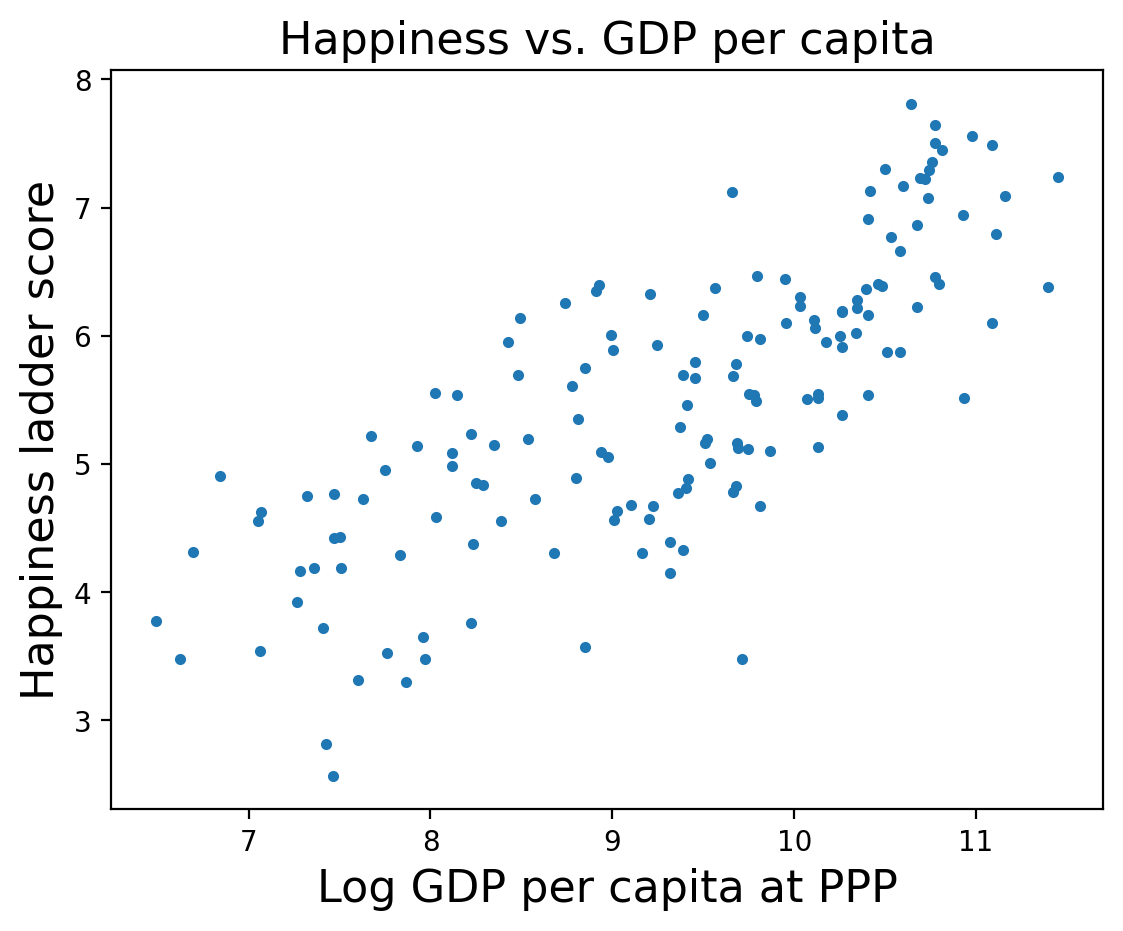

In [8]:
plt.plot(log_gdp, score, '.')
plt.xlabel('Log GDP per capita at PPP', size = 16)
plt.ylabel('Happiness ladder score', size = 16)
plt.title('Happiness vs. GDP per capita', size = 16);

Now we'll estimate the parameters of a regression model using PyMC:

$$y = a x + b + \epsilon$$

where $y$ is the dependent variable (ladder score), $x$ is the predictive variable (log GDP) and $\epsilon$ is a series of values from a normal distribution with mean 0 standard deviation $\sigma$.

$a$ and $b$ are the slope and intercept of the regression line.
They are unknown parameters, so we will use the data to estimate them.

## Introducing PyMC

PyMC is a Python library that provides several MCMC methods.

Here's how we specify this model in PyMC.  After importing `pymc`, we create a `Model` object named `model` and specify a model of the process that generates the data:

In [9]:
import pymc as pm 

x_data = log_gdp
y_data = score

with pm.Model() as model:
    a = pm.Uniform('a', 0, 4)
    b = pm.Uniform('b', -4, 4)
    sigma = pm.Uniform('sigma', 0, 2)

    y_est = a * x_data + b
    y = pm.Normal('y', 
                  mu=y_est, sigma=sigma, 
                  observed=y_data)

WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.



* first we specify the prior distributions on the parameters $a$, $b$, and  $\sigma$, so we set the prior distributions for the parameters `a`, `b`, and `sigma` as uniform with ranges that are wide enough to cover the posterior distributions.



* Then we calculate `y_est`, the estimated value of the dependent variable, based on the regression equation $ax + b$



* Finally, we specify the likelihood, the probability of observing our data `y_data` given a normal distribution with mean `y_est` and standard deviation $\sigma$ (equivalent to looking at the likelihood of the residual `y_data-y_est` for a normal distribution w/ mean 0 and s.d. $\sigma$)


Note: if you are not familiar with the `with` statement in Python, it is a way to associate a block of statements with an object. In this example, the indented statements are associated with the new `Model` object.  

Notice how the data are included in the model:

* The values of the predictive variable, `x_data`, are used to compute `y_est`.

* The values of the dependent variable, `y_data`, are provided as the observed values of `y`.


Now we can use this model to generate a sample from the posterior distribution.

In [10]:
with model:
    idata = pm.sample(500)

/home/pawel/miniconda3/lib/python3.9/site-packages/pytensor/tensor/rewriting/elemwise.py:1019: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/pawel/miniconda3/lib/python3.9/site-packages/pytensor/tensor/rewriting/elemwise.py:1019: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 71 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


PyMC works by running MCMC on your model.


* Depending on the model, PyMC uses one of several MCMC methods; in this example, it used the [No U-Turn Sampler](https://en.wikipedia.org/wiki/Hamiltonian_Monte_Carlo#No_U-Turn_Sampler) (NUTS), which is one of the most efficient and reliable methods we have.



* As described in the last lecture, when the sampler starts, the first values it generates are usually not a representative sample from the posterior distribution, so these values are discarded.  



* Instead of using a single Markov chain, PyMC uses multiple chains.  Then we can compare results from multiple chains to make sure they are consistent.


When you run the sampler, you might get warning messages about "divergences" and the "acceptance probability". Our previous  lessons in the theory behind MCMC might give you some intution into these warnings.

The result is an object that contains samples from the joint posterior distribution of `a`, `b`, and `sigma`.

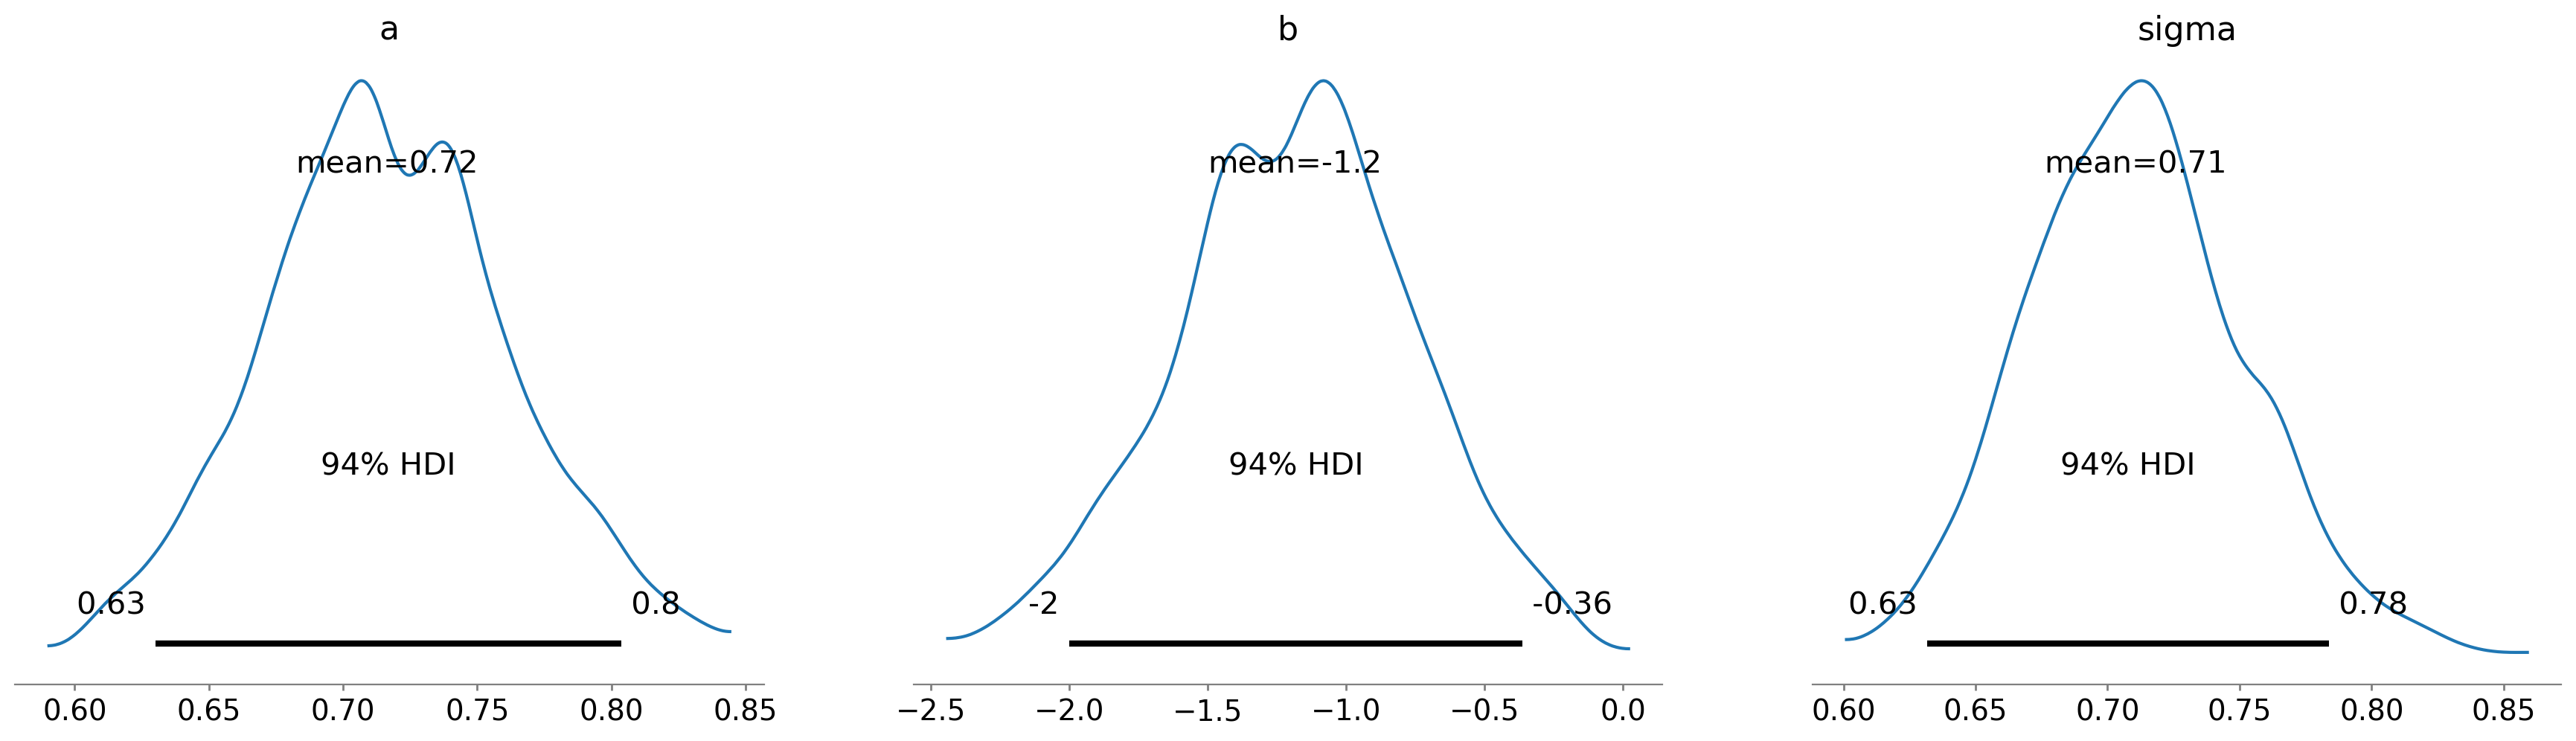

In [11]:
import arviz as az
az.plot_posterior(idata, var_names=['a', 'b', 'sigma']);

The graphs show the distributions of the samples, estimated by KDE, and 94% credible intervals.  In the figure, "HDI" stands for ["highest-density interval"](https://www.sciencedirect.com/topics/mathematics/highest-density-interval).

In [12]:
print('Slope MMSE: {:0.3f}'.format(az.summary(idata)['mean']['a']))
print('Intercept MMSE: {:0.3f}'.format(az.summary(idata)['mean']['b']))

Slope MMSE: 0.716
Intercept MMSE: -1.186


The estimated slope is about 0.72, which suggests that an increase of one unit in log-GDP is associated with an increase of 0.72 units on the happiness ladder (the values in the posterior distribution of `sigma` seem plausible, thought it's hard to know what to expect).

The simple regression model has only three parameters, so we could have used a grid algorithm. But the regression model in the happiness report has six predictive variables, so it has eight parameters in total, including the intercept and `sigma`.

It is not practical to compute a grid approximation for a model with eight parameters. Even a coarse grid, with 20 points along each dimension, would have more than 25 billion points. And with 153 countries, we would have to compute almost 4 trillion likelihoods.

But PyMC can handle a model with eight parameters comfortably, as we'll see next.

## Multiple Regression

Before we implement the multiple regression model, we'll select the columns we need from the `DataFrame`.

In [13]:
columns = ['Ladder score',
           'Logged GDP per capita',
           'Social support',
           'Healthy life expectancy',
           'Freedom to make life choices',
           'Generosity',
           'Perceptions of corruption']

subset = df[columns]

In [14]:
subset.head(3)

,Ladder score,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
0,7.8087,10.639267,0.954330,71.900826,0.949172,-0.059482,0.195445
1,7.6456,10.774001,0.955991,72.402504,0.951444,0.066202,0.168489
2,7.5599,10.979933,0.942847,74.102448,0.921337,0.105911,0.303728


The predictive variables have different units: log-GDP is in log-dollars, life expectancy is in years, and the other variables are on arbitrary scales.
To make these factors comparable, We'll standardize the data so that each variable has mean 0 and standard deviation 1.

In [15]:
standardized = (subset - subset.mean()) / subset.std()

Now let's build the model.
We'll extract the dependent variable.

In [16]:
y_data = standardized['Ladder score']

And the dependent variables.

In [17]:
x1 = standardized[columns[1]]
x2 = standardized[columns[2]]
x3 = standardized[columns[3]]
x4 = standardized[columns[4]]
x5 = standardized[columns[5]]
x6 = standardized[columns[6]]

And here's the model.  `b0` is the intercept; `b1` through `b6` are the parameters associated with the predictive variables.

In [18]:
with pm.Model() as model2:
    b0 = pm.Uniform('b0', -4, 4)
    b1 = pm.Uniform('b1', -4, 4)
    b2 = pm.Uniform('b2', -4, 4)
    b3 = pm.Uniform('b3', -4, 4)
    b4 = pm.Uniform('b4', -4, 4)
    b5 = pm.Uniform('b5', -4, 4)
    b6 = pm.Uniform('b6', -4, 4)
    sigma = pm.Uniform('sigma', 0, 2)

    y_est = b0 + b1*x1 + b2*x2 + b3*x3 + b4*x4 + b5*x5 + b6*x6
    y = pm.Normal('y', 
                  mu=y_est, sigma=sigma, 
                  observed=y_data)

In [19]:
with model2:
    idata2 = pm.sample(500)

/home/pawel/miniconda3/lib/python3.9/site-packages/pytensor/tensor/rewriting/elemwise.py:1019: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/pawel/miniconda3/lib/python3.9/site-packages/pytensor/tensor/rewriting/elemwise.py:1019: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b0, b1, b2, b3, b4, b5, b6, sigma]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 48 seconds.


From `idata2` we can extract samples from the posterior distributions of the parameters and get their means.

In [20]:
param_names = ['b1', 'b3', 'b3', 'b4', 'b5', 'b6']

means = az.summary(idata2)['mean'][param_names]

We can also compute 94% credible intervals (between the 3rd and 97th percentiles).

In [21]:
def credible_interval(sample):
    """Compute 94% credible interval."""
    ci = np.percentile(sample, [3, 97])
    return np.round(ci, 3)

cis = [credible_interval(idata2['posterior'][name])
       for name in param_names]

And summarize the results:

In [22]:
index = columns[1:]
table = pd.DataFrame(index=index)
table['Posterior mean'] = np.round(np.array(means), 3)
table['94% CI'] = cis
table

,Posterior mean,94% CI
Logged GDP per capita,0.245,"[0.077, 0.41]"
Social support,0.223,"[0.065, 0.381]"
Healthy life expectancy,0.223,"[0.065, 0.381]"
Freedom to make life choices,0.189,"[0.087, 0.287]"
Generosity,0.055,"[-0.032, 0.141]"
Perceptions of corruption,-0.098,"[-0.195, -0.0]"


It looks like GDP has the strongest association with happiness (or satisfaction), followed by social support, life expectancy, and freedom.

After controlling for those other factors, the parameters of the other factors are substantially smaller. Since the CI for generosity includes 0, it is plausible that generosity is not substantially related to happiness, at least as they were measured in this study.

This example demonstrates the power of MCMC to handle models with more than a few parameters.

## Summary

In this lecture we first used PyMC to implement a simple regression model.

Then we implemented a multiple regression model that would not have been possible to compute with a grid approximation.

MCMC is more powerful than grid methods, but that power comes with some disadvantages. These disadvantages come from the need for the underlying Markov chain to converge as discussed in the previous two lectures. 

If you are using a package like PyMC, it will try to alert you to convergence issues with warnings about tuning steps, divergences, and effective samples.  You will have to use your knowledge of the underlying MCMC algorithm and think about how to address issues around convergence.